<a href="https://colab.research.google.com/github/BenjaAR/LAB16_AQUINO_REYES/blob/main/SEM16_LAB_MINERIA_AQUINO_REYES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Instalar librerías necesarias (si no están)
!pip install -q pandas numpy matplotlib seaborn scikit-learn category_encoders imbalanced-learn optuna

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from category_encoders import OneHotEncoder
from scipy.stats import zscore
import warnings
warnings.filterwarnings('ignore')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 15.7 MB/s eta 0:00:00


In [2]:
# Descargar datos
url_data = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
url_test = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test'

col_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
    'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
    'hours-per-week', 'native-country', 'income'
]

# Cargar datos
df_train = pd.read_csv(url_data, names=col_names, na_values=" ?", skipinitialspace=True)
df_test = pd.read_csv(url_test, names=col_names, skiprows=1, na_values=" ?", skipinitialspace=True)

# Arreglar etiquetas en test
df_test['income'] = df_test['income'].str.replace(".", "", regex=False)

# Unir datasets
df = pd.concat([df_train, df_test], axis=0).reset_index(drop=True)
df.head()


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
# ================================================================
# 🧼 a. PREPROCESAMIENTO: CORRECCIÓN, IMPUTACIÓN, OUTLIERS, TRANSFORMACIÓN
# ================================================================


age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64


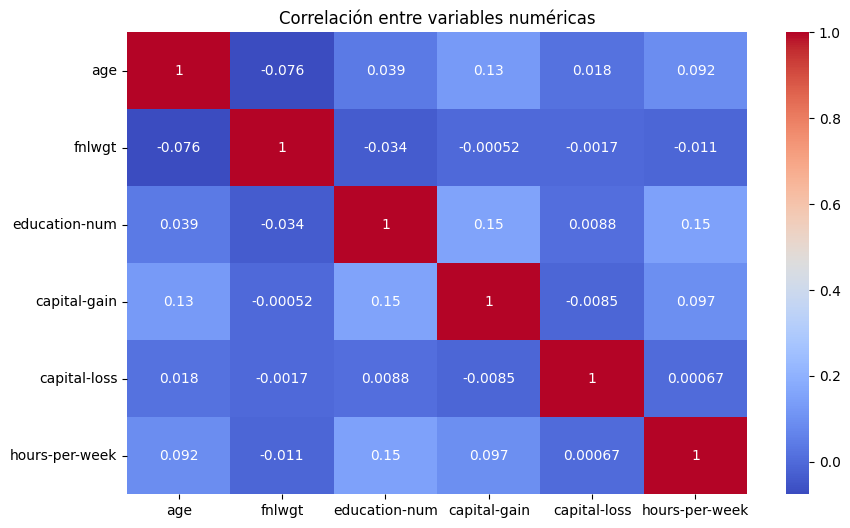

In [4]:
# Valores faltantes
print(df.isnull().sum())

# Imputación con moda para categóricas
cat_cols = df.select_dtypes(include='object').columns
for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Outliers univariados con z-score para variables numéricas
num_cols = df.select_dtypes(include='number').columns
df_z = df[(np.abs(zscore(df[num_cols])) < 3).all(axis=1)]  # mantener solo valores sin outliers

# Outliers multivariados con distancia de Mahalanobis (opcional, se omite para simplicidad)

# Transformación de variables categóricas - mantendremos nombres originales por ahora

# Correlación
plt.figure(figsize=(10, 6))
sns.heatmap(df_z[num_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlación entre variables numéricas")
plt.show()


In [ ]:
# ================================================================
# 📊 b. IV, DUMMIES, ESCALAMIENTO, DIVISIÓN Y BALANCEO
# ================================================================


In [5]:
# Simplificado cálculo de Information Value (IV)
def calc_iv(df, feature, target):
    lst = []
    for val in df[feature].unique():
        temp = df[df[feature] == val]
        good = ((temp[target] == '<=50K').sum()) + 0.5
        bad = ((temp[target] == '>50K').sum()) + 0.5
        lst.append({'Value': val, 'IV': (bad / bad.sum() - good / good.sum()) *
                                       np.log((bad / bad.sum()) / (good / good.sum()))})
    iv_df = pd.DataFrame(lst)
    return iv_df['IV'].sum()

# Calcular IV para todas las variables categóricas
iv_scores = {}
for col in cat_cols.drop('income'):
    iv_scores[col] = calc_iv(df_z, col, 'income')
iv_sorted = sorted(iv_scores.items(), key=lambda x: x[1], reverse=True)
print("IV por variable:", iv_sorted)


IV por variable: [('workclass', np.float64(0.0)), ('education', np.float64(0.0)), ('marital-status', np.float64(0.0)), ('occupation', np.float64(0.0)), ('relationship', np.float64(0.0)), ('race', np.float64(0.0)), ('sex', np.float64(0.0)), ('native-country', np.float64(0.0))]


In [6]:
# Selección de las mejores variables categóricas con IV > 0.02
selected_cat = [k for k, v in iv_sorted if v > 0.02]

# Convertir income a binario
df_z['income'] = df_z['income'].map({'>50K': 1, '<=50K': 0})

# Variables finales
X = df_z[selected_cat + list(num_cols)]
y = df_z['income']

# Dummies para categóricas
X = pd.get_dummies(X, columns=selected_cat, drop_first=True)

# Escalamiento
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# División
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Balanceo
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)


In [ ]:
# ================================================================
# 🤖 c. ENTRENAMIENTO DE MODELOS Y BÚSQUEDA DE HIPERPARÁMETROS
# ================================================================


In [7]:
# Definir modelos y parámetros
models = {
    "KNN": (KNeighborsClassifier(), {"n_neighbors": [3, 5, 7]}),
    "SVM": (SVC(), {"C": [0.1, 1, 10], "kernel": ["linear", "rbf"]}),
    "Logistic": (LogisticRegression(), {"C": [0.01, 0.1, 1, 10]}),
    "Tree": (DecisionTreeClassifier(), {"max_depth": [5, 10, 20]}),
    "RandomForest": (RandomForestClassifier(), {"n_estimators": [100, 200], "max_depth": [10, 20]})
}

# Entrenamiento y evaluación
best_score = 0
best_model = None
best_params = {}

for name, (model, params) in models.items():
    grid = GridSearchCV(model, params, cv=3, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train_bal, y_train_bal)
    preds = grid.predict(X_test)
    acc = accuracy_score(y_test, preds)
    print(f"Modelo: {name} | Accuracy: {acc:.4f} | Mejores Parámetros: {grid.best_params_}")
    if acc > best_score:
        best_score = acc
        best_model = name
        best_params = grid.best_params_

print(f"\n✅ Mejor modelo: {best_model} con Accuracy: {best_score:.4f} y parámetros: {best_params}")


Modelo: KNN | Accuracy: 0.7340 | Mejores Parámetros: {'n_neighbors': 3}
Modelo: SVM | Accuracy: 0.7513 | Mejores Parámetros: {'C': 10, 'kernel': 'rbf'}
Modelo: Logistic | Accuracy: 0.7453 | Mejores Parámetros: {'C': 0.01}
Modelo: Tree | Accuracy: 0.7498 | Mejores Parámetros: {'max_depth': 20}
Modelo: RandomForest | Accuracy: 0.7800 | Mejores Parámetros: {'max_depth': 20, 'n_estimators': 200}

✅ Mejor modelo: RandomForest con Accuracy: 0.7800 y parámetros: {'max_depth': 20, 'n_estimators': 200}
